In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
from ctf.functions2d import branin
Br = branin.Branin()
X1_domain = Br.domain[0]
X2_domain = Br.domain[1]

In [3]:
X1 = np.linspace(X1_domain[0], X1_domain[1],10)
X2 = np.linspace(X2_domain[0], X2_domain[1],10)

Xtt1, Xtt2 = np.meshgrid(X1, X2)
X_train = np.zeros(shape =(np.ravel(Xtt1).shape[0],2))
X_train[:,0] = np.ravel(Xtt1) 
X_train[:,1] = np.ravel(Xtt2)

In [4]:
Xtrain_mean = np.mean(X_train, 0)
Xtrain_std = np.std(X_train, 0)
X_train_norm = (X_train - Xtrain_mean)/Xtrain_std
Y_train = Br.cost(X_train.T)

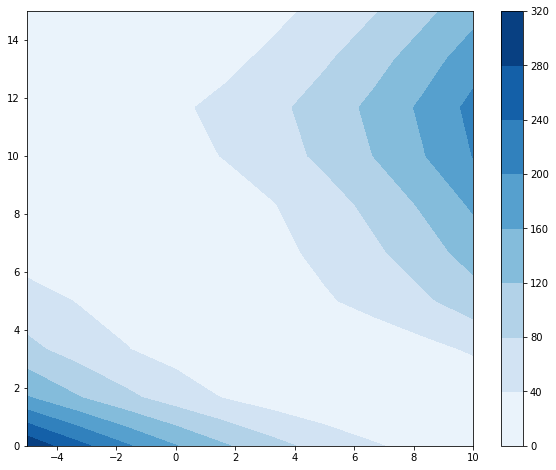

In [5]:
plt.figure(figsize=(10,8))
num_grid = X1.shape[0]
c = plt.contourf(X1, X2, Y_train.reshape((num_grid, num_grid), order='F'), cmap=plt.cm.Blues)
plt.colorbar(c)

In [6]:
#build the model
k1 = gpflow.kernels.RBF(1)
k2 = gpflow.kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(X_train_norm, Y_train[:,None], k1, k2, nonstat)

In [7]:
# Lengthscale 1 GP priors 
#m.kern1.variance = 0.1
#m.kern1.variance.fixed = True
#m.kern1.lengthscales = 0.5
#m.kern1.lengthscales.fixed = True
m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# Lengthscale 2 GP priors
#m.kern2.variance = 0.1
#m.kern2.variance.fixed = True
#m.kern2.lengthscales = 0.5
#m.kern2.lengthscales.fixed = True
m.kern2.variance.prior = gpflow.priors.Gamma(1., 1.)
m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)

# Non stationary signal variance prior
#m.nonstat.signal_variance = 100
#m.nonstat.signal_variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)

m.likelihood.variance = 0.01
m.likelihood.variance.fixed = True

In [8]:
import tensorflow as tf
m.optimize(maxiter=10000)

      fun: array([ 292.73524358])
 hess_inv: <305x305 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.60862285e+01,   7.68331952e+01,   1.07978917e+01,
        -1.36213108e+02,  -2.01973212e+02,  -1.19530511e+02,
         5.07742696e+00,   1.37167379e+02,   1.70388445e+02,
         4.31976855e+01,   3.77010441e+00,  -3.11429556e-01,
        -6.25919561e-02,  -1.97801049e+00,  -1.89608183e+00,
        -2.99785936e+00,  -3.91449685e-01,  -5.83134272e-01,
         1.14102943e+00,   9.95144354e-01,  -5.17923192e+00,
         3.70018116e-01,  -2.11653996e+00,   2.86851364e+00,
         1.42726363e+00,   4.01454980e+00,  -2.12062789e+00,
        -5.29560370e-01,  -9.44659833e-02,  -1.42064526e+00,
         1.58765151e+00,   4.88722201e-02,   2.33070540e+00,
        -3.09733409e+00,  -4.24220451e+00,   1.97913767e-01,
         4.04435782e+00,   3.35069579e+00,  -3.39773238e-01,
         9.89043350e-01,   2.47519262e-01,  -3.24372868e-01,
        -5.17792610e-01,   1.63756105e+00

In [9]:
#samples = m.sample(200, verbose=True, epsilon=0.005, thin = 2, burn = 100, Lmax = 160)

In [10]:
mean, var = m.predict_f(X_train_norm)

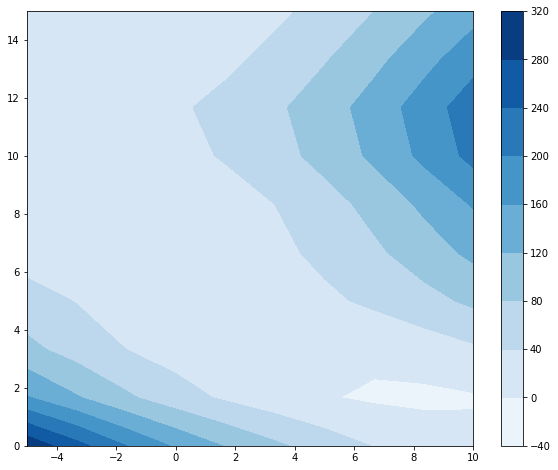

In [11]:
plt.figure(figsize=(10,8))
num_grid = X1.shape[0]
c = plt.contourf(X1, X2, mean.reshape((num_grid, num_grid), order='F'), cmap=plt.cm.Blues)
plt.colorbar(c)

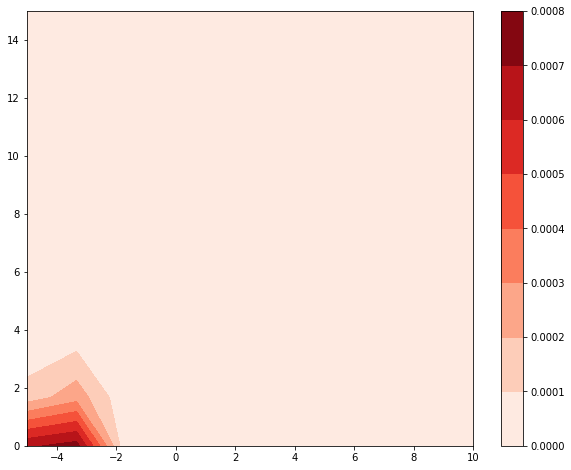

In [12]:
plt.figure(figsize=(10,8))
num_grid = X1.shape[0]
c = plt.contourf(X1, X2, np.diag(var).reshape((num_grid, num_grid), order='F'), cmap=plt.cm.Reds)
plt.colorbar(c)

In [13]:
#samples = m.sample(200, verbose=True, epsilon=0.0005, thin = 2, burn = 100, Lmax = 360)

In [24]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    #plt.fill_between(Xgrid[:,0], L, U,
    #                 color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [28]:
X1t = np.linspace(X1_domain[0], X1_domain[1],100)
X2t = np.linspace(X2_domain[0], X2_domain[1],100)
X_test = np.zeros(shape =(X1t.shape[0],2))
X_test[:,0] = X1t
X_test[:,1] = X2t
X_testnorm = (X_test - Xtrain_mean)/Xtrain_std

In [29]:
ml1, vl1, ml2, vl2 = m.predict_l(X_train_norm)

In [30]:
lower1 = ml1 - 2*np.sqrt(vl1)
upper1 = ml1 + 2*np.sqrt(vl1)

MeanL1 = np.exp(ml1)
LowerL1 = np.exp(lower1)
UpperL1 = np.exp(upper1)


In [31]:
lower2 = ml2 - 2*np.sqrt(vl2)
upper2 = ml2 + 2*np.sqrt(vl2)

MeanL2 = np.exp(ml2)
LowerL2 = np.exp(lower2)
UpperL2 = np.exp(upper2)


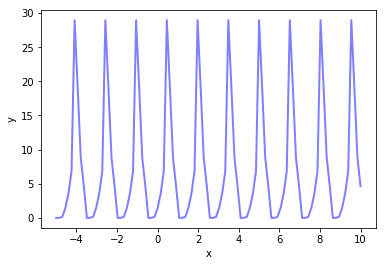

In [33]:
visualize_l(X1t,MeanL1,UpperL1, LowerL1)

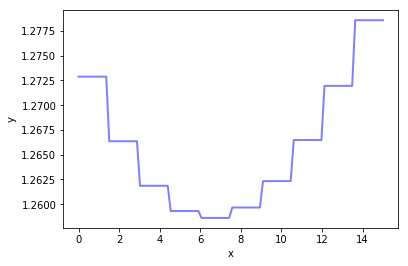

In [34]:
visualize_l(X2t,MeanL2,UpperL2, LowerL2)